## Preprocess data for training and validation

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from utils import *

rand_seed = 42

datapath = "/home/derekdb/notebooks/uw-geohack-challenge/data"

In [ ]:
# download training data
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('bulentsiyah/semantic-drone-dataset', path=datapath, unzip=True)

In [11]:
# specify paths for later use
path = Path(datapath)/'semantic_drone_dataset'
path_lbl_semantic = path/'label_images_semantic' #path for semantic masks
path_lbl_bin = path/'label_images_bin' # path for binary masks
path_lbl_bin_resized = path/'label_images_bin_resized'
path_img = path/'original_images' # path for original images
path_img_resized = path/'original_images_resized' # resize to work with patches

## Resize images to 672x448 to work with patches

In [ ]:
# The eval image is extremely large. To work with limited GPU resources, the eval image is to be split to patches.
# Each patch will be segmented, and all the segmentation masks are to be merged together to generate the final
# result. The training images all come with standard size (6000,4000) with small receptive fields compared to the
# eval image. Therefore, the training images are to be downsampled to (672,448) to match the patch size which is 
# of similar receptive fields, and also preserve aspect ratio. 

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/derekdb/notebooks/uw-geohack-challenge/data/semantic_drone_dataset/original_images/378.jpg'),
 PosixPath('/home/derekdb/notebooks/uw-geohack-challenge/data/semantic_drone_dataset/original_images/446.jpg'),
 PosixPath('/home/derekdb/notebooks/uw-geohack-challenge/data/semantic_drone_dataset/original_images/376.jpg')]

In [ ]:
path_img_resized.mkdir(parents=True, exist_ok=True)
batch_process(resize_img, str(path_img), str(path_img_resized))

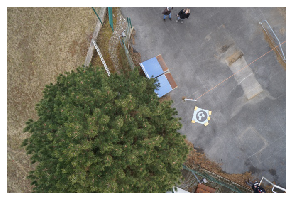

In [24]:
# show a resized image
fnames = get_image_files(path_img_resized)
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(5,5))

## Prepare segmentation masks

In [ ]:
# The original ground truth masks are for semantic segmentation. However, we are only asked to segment trees. To
# simplify the task, the semantic segmentation masks are to be converted to binary masks with pixels corresponding
# to trees being 1 and otherwise 0. The original code for tree is 19.

In [10]:
path_lbl_bin.mkdir(parents=True, exist_ok=True)
batch_process(replace_pixel_vals, str(path_lbl_semantic), str(path_lbl_bin))

In [12]:
# downsample binary masks to the same size as images
path_lbl_bin_resized.mkdir(parents=True, exist_ok=True)
batch_process(resize_mask, str(path_lbl_bin), str(path_lbl_bin_resized))

In [22]:
get_y_fn = lambda x: (path_lbl_bin_resized/x.stem).with_suffix('.png')

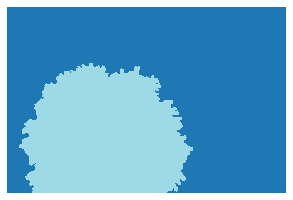

In [25]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)
# compare to the image, the mask looks that it works

## Create validation list

In [ ]:
# create a list of validation data for network training
# fns = [x.name for x in fnames]
# from random import sample
# random.seed(rand_seed)
# valid_list = sample(fns, len(fns)//5)
# print(valid_list)
# with open(path/'valid.txt', 'w') as handle:
#     handle.write('\n'.join(valid_list))

## Create patches from eval_data

In [29]:
eval_path = Path(datapath)/'eval_data'
eval_img = eval_path/'images/ortho_eval.tif'
eval_patch_dir = eval_path/'patches'
img2tiles(str(eval_img), dst_folder=str(eval_patch_dir))

shape of image is (7068, 5160, 3)


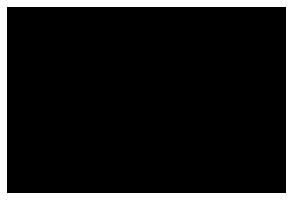

In [36]:
fnames = get_image_files(eval_patch_dir)
img = open_image(fnames[80])
img.show(figsize=(5,5))

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

codes = array(['Background', 'Tree'])